# Pr-YBCO version Fit modes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from importlib import reload
import alris_functions2
reload(alris_functions2)
from alris_functions2 import shift_atoms, transform_list_hkl_p63_p65, get_structure_factors , atom_position_list
from matplotlib.markers import MarkerStyle
from time import time

tf.keras.utils.set_random_seed(1)

Define the function containing the fitting parameters

<span style="color:yellow">Note on actual unit cell structure refinement problem:</span>
- `fun_tf()` correspond to the **structure factor calculation function** (one has to convert it to a **TF-compatible** function)
- <span style="color:red">If conversion to TF-compatible function is not possible, then this approach will probably not work (or becomes much more tedious at least)</span>

In [2]:
#convert the simulated data to log10 scale

def log10(x):
  numerator = tf.math.log(x)
  denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
  return numerator / denominator

In [3]:
experimental_data = pd.read_csv('C:/Users/User/Desktop/uzh_intern/CrystalClearFit/alrisDistortionFit/PBCO/raw_data/LOGcombined_peaks.csv')
hkl_list = experimental_data[["h", "k", "l"]].values.tolist()
hkl_list = tf.convert_to_tensor(hkl_list, dtype=tf.float32)

matrix = np.loadtxt('C:/Users/User/Desktop/uzh_intern/CrystalClearFit/alrisDistortionFit/PBCO/new_PBCO_fit/matrix.txt', dtype=np.float32)
matrix = tf.convert_to_tensor(matrix, dtype=tf.float32)

Sample the "training data" (features and labels)

<span style="color:yellow">Note on actual unit cell structure refinement problem:</span>
- The features are the (h,k,l) coordinates (e.g. a vector of size `n_features` x 3, i.e. `n_dim = 3`)
- Maybe one has to normalize the features (i.e. not using integers but floats between -1 (0) and 1)? Before passing them to the structure calculation function, they should be again rescaled to integers
- The labels would be the experimental intensities (again, maybe have to be normalized to the range between 0 and 1)

Max label ERR: 1000.0
min label ERR: 1.0
Features shape: (5367, 3)
Labels shape: (5367, 1)
error shape: (5367, 1)
Max label: 1.0759183
min label : 0.0


(array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        5186.,    0.,    0.,    0.]),
 array([0.        , 0.02195752, 0.04391503, 0.06587255, 0.08783007,
        0.10978758, 0.1317451 , 0.15370262, 0.17566013, 0.19761765,
        0.21957517, 0.24153268, 0.2634902 , 0.28544772, 0.30740523,
        0.32936275, 0.35132027, 0.37327778, 0.3952353 , 0.41719282,
        0.43915033, 0.46110785, 0.48306537, 0.50502288, 0.5269804 ,
        0.54893792, 0.57089543, 0.59285295, 0.61481047, 0.63676798,
        0.6587255 , 0.68068302, 0.70264053, 0.72459805, 0.74655557,
        0.76851308, 0.7904706 , 0.81242812, 0.83438563, 0.85634315,
        0.87830067, 0.90025818, 0.9222157 , 0.94417322, 0.96613

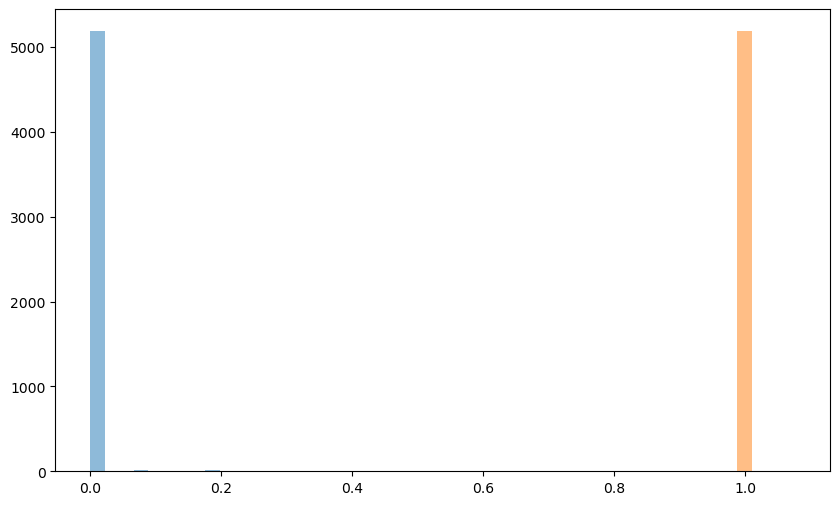

In [4]:
n_features = experimental_data.shape[0]
n_dim = 3

features = hkl_list
labels = experimental_data["intensity_exp"].tolist()
vol_err = experimental_data["intensity_exp_err"].tolist()

global max_intensity
max_intensity = tf.reduce_max(labels)

labels = labels / np.max(labels) #Normalize labels
labels = labels / np.sum(labels) * 60  # Normalize to sum to 60

labels_err = []

for label, err in zip(labels, vol_err):
    if label == 0:
        labels_err.append(1)  # Assign a high error for zero labels
    else:
        labels_err.append(1000)  # Inverse error for each label

labels_err = tf.convert_to_tensor(labels_err, dtype=tf.float32)
labels = tf.convert_to_tensor(labels, dtype=tf.float32)

labels = tf.expand_dims(labels, axis=-1)  # Ensure labels are 2D
labels_err = tf.expand_dims(labels_err, axis=-1)  # Ensure labels_err are 2D

print("Max label ERR:", np.max(labels_err))
print("min label ERR:", np.min(labels_err))
print("Features shape:", features.shape)
print("Labels shape:", labels.shape)
print('error shape:', labels_err.shape)
print("Max label:", np.max(labels))
print("min label :", np.min(labels))
#bin from0 to 0.0025 with 50 bins
plt.figure(figsize=(10, 6))

plt.hist(labels.numpy(), bins=np.linspace(0 , np.max(labels) , 50), alpha=0.5, label='Labels')
plt.hist(labels_err.numpy(), bins=np.linspace(0 , np.max(labels) , 50), alpha=0.5, label='Labels Error')


In [ ]:
def fun_tf(hkl_list, pars, matrix):
    """
    Fast computation of structure factors with parameter-dependent structure.
    """
    # stack parameters
    pars_tensor = tf.stack(pars)  # shape (params,)

    atom_shift_list = shift_atoms(matrix , (pars_tensor))
    atom_shift_list = atom_shift_list[:,0]
    atom_shift_list = tf.unstack(atom_shift_list)

    modified_struct = atom_position_list(*atom_shift_list)

    hkl_list = transform_list_hkl_p63_p65(hkl_list)

    # Get structure factors
    sf_hkl = get_structure_factors(hkl_list, modified_struct)
    intensity = (abs(sf_hkl)) ** 2

    w = tf.constant(0.0004877332589381476, dtype=tf.float32)  # Debye-Waller factor 
    qnorms = tf.norm(tf.cast(hkl_list, tf.float32), axis=1)
    intensity = intensity * tf.exp(- w * qnorms ** 2)  # Apply Debye-Waller factor
    
    #intensity = log10(intensity + 1)  # Convert to log10 scale
    sim_intensity = intensity / tf.reduce_max(intensity)  # Normalize to max intensity
    sim_intensity = sim_intensity / tf.reduce_sum(sim_intensity) * 60
    return sim_intensity



Define a simple model

<span style="color:yellow">Note on actual unit cell structure refinement problem:</span>
- The six parameters (a,b,c,d,e,f) correspond to the fractional atomic shifts in the modes w.r.t. unit cell lengths
- Instead of `sigmoid`, `tanh` should be applied to the parameters before passing them to the structure factor calculation function (ensures smoother gradient landscape)
- The `tanh` function can furthermore be limited to a specific range (e.g. if atomic distortions should not exceed +- 0.1)

In [6]:
class FunAsLayer(tf.keras.layers.Layer):
    def __init__(self, matrix , max_mode_amps,**kwargs):
        super().__init__(**kwargs)
        self.max_mode_amps = max_mode_amps
        self.matrix = matrix

    def build(self, input_shape):
        self.param = self.add_weight(name='param', shape=(1290,), initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.2, seed=1), trainable=True)
        super().build(input_shape)

    def call(self, inputs):
        # Apply tanh to ensure parameters stay within the [-1, 1] range then multiply by max_mode_amps so each parameter is scaled corresponding to the element in max_mode_amps
        pretransform = tf.tanh(self.param)
        transformed_params = pretransform * self.max_mode_amps  # Scale parameters

        output = fun_tf(inputs, transformed_params , self.matrix)
        return tf.reshape(output , [-1])  # Ensure output is 1D




Create optimizer and define loss function

<span style="color:yellow">Note on actual unit cell structure refinement problem:</span>
- The learning rate must be determined by experimentation (same holds for the batch size and the number of epochs below)
- As a loss function, one can try either MSE or R-score (MSE seems to be the more "natural choice" in this case)

In [7]:
"""
# R-Score based on intensity
class RFactorLoss(tf.keras.losses.Loss):
    def call(self, y_true, y_pred):
        return tf.reduce_sum(tf.abs(y_true - y_pred)) / tf.reduce_sum(y_true)
"""
    
# mean squared error
class PerSampleMSE(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__(reduction=tf.keras.losses.Reduction.NONE)

    def call(self, y_true, y_pred):
        squared_error = tf.square(y_true - y_pred)
        per_sample_mse = tf.reduce_mean(squared_error, axis=-1)
        return per_sample_mse  # shape (batch_size,)

class WeightedMeanSquaredError(tf.keras.losses.Loss):
    def __init__(self,reduction=tf.keras.losses.Reduction.AUTO, name='WeightedMeanSquaredError'):
        super(WeightedMeanSquaredError, self).__init__(reduction=reduction, name=name)

    def call(self, y_true, y_pred):
        return tf.keras.losses.mean_squared_error(y_true, y_pred)

    def num_of_elements(self, sample_weight):
        return tf.size(sample_weight).numpy()
    
    def __call__(self, y_true, y_pred, sample_weight):
        #return super().__call__(y_true, y_pred, 1)
        # 1/n *  sum(weights * mse(y_p - y_t))
        actual_loss = super().__call__(y_true, y_pred, sample_weight)
        num_of_el = tf.py_function(func=self.num_of_elements, inp = [sample_weight], Tout=tf.float32)

        # dividing by sum of all weights in this batch
        # (sum(weights * mse(y_p - y_t))) / sum(weights)
        wmse_loss = actual_loss * (num_of_el / tf.math.reduce_sum(sample_weight))
        return wmse_loss
  

# Define the custom metric function
def r_factor_metric(y_true, y_pred):
    labels = y_true
    return tf.reduce_sum(tf.abs(labels - y_pred)) / tf.reduce_sum(labels)


Train the model for n iterations (to try different initial weights)

<span style="color:yellow">Note on actual unit cell structure refinement problem:</span>
- The number of iterations defines the "starting position" $w_0$ of the gradient descent algorithm
- Because there are probably many local minima, changing $w_0$ allows the algorithm to find different minima and increases the chances of finding the global minima

Learning rate: 0.1
Epoch 1/75
1/1 [==============================] - 44s 44s/step - loss: 0.1848 - r_factor_metric: 1.8810
Epoch 2/75
1/1 [==============================] - 0s 210ms/step - loss: 0.1634 - r_factor_metric: 1.7482
Epoch 3/75
1/1 [==============================] - 0s 213ms/step - loss: 0.1453 - r_factor_metric: 1.6188
Epoch 4/75
1/1 [==============================] - 0s 205ms/step - loss: 0.1336 - r_factor_metric: 1.5297
Epoch 5/75
1/1 [==============================] - 0s 208ms/step - loss: 0.1259 - r_factor_metric: 1.4866
Epoch 6/75
1/1 [==============================] - 0s 209ms/step - loss: 0.1208 - r_factor_metric: 1.4590
Epoch 7/75
1/1 [==============================] - 0s 211ms/step - loss: 0.1187 - r_factor_metric: 1.4503
Epoch 8/75
1/1 [==============================] - 0s 207ms/step - loss: 0.1173 - r_factor_metric: 1.4443
Epoch 9/75
1/1 [==============================] - 0s 211ms/step - loss: 0.1146 - r_factor_metric: 1.4197
Epoch 10/75
1/1 [====================

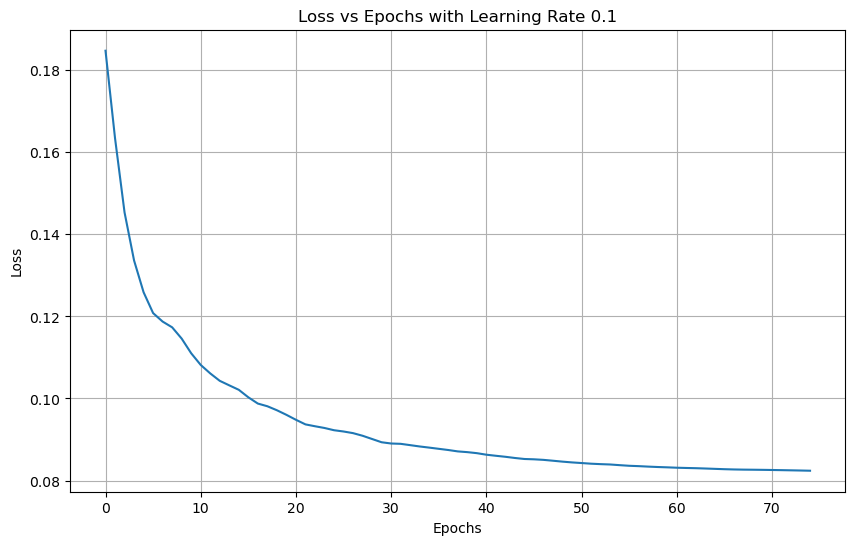

In [8]:
lr = [1e-1]
best_pars_overall = None
best_rf_overall = np.inf
best_loss_overall = []

for learning_rate in lr:
    time_start = time()
    print(f"Learning rate: {learning_rate}")
    optim = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    max_mode_amps = np.loadtxt('C:/Users/User/Desktop/uzh_intern/CrystalClearFit/alrisDistortionFit/PBCO/new_PBCO_fit/new_PBCO_mode_amp_bounds_ver2.txt', dtype=np.float32 , delimiter=',')
    max_mode_amps = tf.convert_to_tensor(max_mode_amps, dtype=tf.float32)
    # max_mode_amps = tf.constant([5.6,6.36,5.6,11.19,11.19,12.73,11.19,12.73,11.19,11.19,12.73,11.19,9.0,7.91,9.0,7.91,9.0,9.0,9.0,7.91,7.91,9.0,7.91,9.0,9.0,9.0,7.91,9.0,7.91,7.91,7.91,7.91,7.91,9.0,7.91,7.91,7.91,7.91,7.91,7.91,7.91,9.0,7.91,7.91,9.0,7.91,9.0,7.91,9.0,9.0,9.0,7.91,7.91,7.91,7.91,7.91,7.91,9.0,7.91,7.91,5.6,6.36,5.6,5.6,6.36,6.36,5.6,6.36,5.6,5.6,6.36,5.6,5.6,6.36,5.6,5.6,6.36,6.36,5.6,6.36,5.6,6.36,6.36,5.6,6.36,6.36,5.6,6.36,6.36,6.36,6.36,6.36,5.6,5.6,6.36,5.6,5.6,6.36,5.6,5.6,6.36,6.36,5.6,6.36,5.6,8.29,7.91,8.04,8.42,8.04,8.42,0.0,15.59,15.83,15.59,15.83,15.59,18.0,15.59,15.83,15.59,18.0,15.59,15.83,15.59,15.83,15.59,18.0,15.59,15.83,11.73,11.19,11.37,11.91,11.73,11.19,11.37,11.91,11.02,12.73,14.7,12.73,11.73,11.19,11.37,11.91,11.73,11.19,11.37,11.91,11.73,11.19,11.37,11.91,11.02,12.73,14.7,12.73,11.73,11.19,11.37,11.91,11.02,11.19,11.19,11.02,11.19,11.19,11.02,12.73,11.19,11.02,11.19,11.19,11.02,11.19,11.19,11.02,11.19,11.19,11.02,12.73,11.19,11.02,11.19,11.19,11.02,11.19,12.73,11.02,11.19,12.73,11.02,12.73,12.73,11.02,11.19,12.73,11.02,11.19,11.19,11.02,11.19,11.19,11.02,12.73,11.19,11.02,11.19,11.19,7.79,9.0,9.14,7.91,9.14,7.91,8.29,7.91,9.14,9.58,8.04,8.42,8.29,7.91,8.04,8.42,8.04,8.42,7.79,9.0,9.14,7.91,9.14,7.91,8.29,7.91,8.04,8.42,8.04,8.42,8.29,7.91,9.14,9.58,8.04,8.42,7.79,9.0,9.14,7.91,9.14,7.91,8.29,7.91,8.04,8.42,9.14,9.58,8.29,7.91,8.04,8.42,9.14,9.58,7.79,9.0,10.39,9.0,10.39,9.0,8.29,7.91,8.04,8.42,9.14,9.58,8.29,7.91,8.04,8.42,8.04,8.42,7.79,9.0,9.14,7.91,9.14,7.91,8.29,7.91,9.14,9.58,8.04,8.42,8.29,7.91,8.04,8.42,8.04,8.42,5.6,6.36,5.6,11.19,11.19,12.73,11.19,12.73,11.19,11.19,12.73,11.19,9.0,7.91,9.0,7.91,9.0,9.0,9.0,7.91,7.91,9.0,7.91,9.0,9.0,9.0,7.91,9.0,7.91,7.91,7.91,7.91,7.91,9.0,7.91,7.91,7.91,7.91,7.91,7.91,7.91,9.0,7.91,7.91,9.0,7.91,9.0,7.91,9.0,9.0,9.0,7.91,7.91,7.91,7.91,7.91,7.91,9.0,7.91,7.91,5.6,6.36,5.6,5.6,6.36,6.36,5.6,6.36,5.6,5.6,6.36,5.6,5.6,6.36,5.6,5.6,6.36,6.36,5.6,6.36,5.6,6.36,6.36,5.6,6.36,6.36,5.6,6.36,6.36,6.36,6.36,6.36,5.6,5.6,6.36,5.6,5.6,6.36,5.6,5.6,6.36,6.36,5.6,6.36,5.6,7.79,9.0,9.14,7.91,9.14,7.91,0.0,15.59,15.83,15.59,15.83,15.59,18.0,15.59,15.83,15.59,18.0,15.59,15.83,15.59,15.83,15.59,18.0,15.59,15.83,11.02,12.73,12.92,11.19,11.02,12.73,12.92,11.19,11.02,12.73,14.7,12.73,11.02,12.73,12.92,11.19,11.02,12.73,12.92,11.19,11.02,12.73,12.92,11.19,11.02,12.73,14.7,12.73,11.02,12.73,12.92,11.19,11.02,11.19,11.19,11.02,11.19,11.19,11.02,12.73,11.19,11.02,11.19,11.19,11.02,11.19,11.19,11.02,11.19,11.19,11.02,12.73,11.19,11.02,11.19,11.19,11.02,11.19,12.73,11.02,11.19,12.73,11.02,12.73,12.73,11.02,11.19,12.73,11.02,11.19,11.19,11.02,11.19,11.19,11.02,12.73,11.19,11.02,11.19,11.19,7.79,9.0,9.14,7.91,9.14,7.91,7.79,9.0,10.39,9.0,9.14,7.91,7.79,9.0,9.14,7.91,9.14,7.91,7.79,9.0,9.14,7.91,9.14,7.91,7.79,9.0,9.14,7.91,9.14,7.91,7.79,9.0,10.39,9.0,9.14,7.91,7.79,9.0,9.14,7.91,9.14,7.91,7.79,9.0,9.14,7.91,10.39,9.0,7.79,9.0,9.14,7.91,10.39,9.0,7.79,9.0,10.39,9.0,10.39,9.0,7.79,9.0,9.14,7.91,10.39,9.0,7.79,9.0,9.14,7.91,9.14,7.91,7.79,9.0,9.14,7.91,9.14,7.91,7.79,9.0,10.39,9.0,9.14,7.91,7.79,9.0,9.14,7.91,9.14,7.91,5.6,6.36,5.6,11.19,11.19,12.73,11.19,12.73,11.19,11.19,12.73,11.19,9.0,7.91,9.0,7.91,9.0,9.0,9.0,7.91,7.91,9.0,7.91,9.0,9.0,9.0,7.91,9.0,7.91,7.91,7.91,7.91,7.91,9.0,7.91,7.91,7.91,7.91,7.91,7.91,7.91,9.0,7.91,7.91,9.0,7.91,9.0,7.91,9.0,9.0,9.0,7.91,7.91,7.91,7.91,7.91,7.91,9.0,7.91,7.91,5.6,6.36,5.6,5.6,6.36,6.36,5.6,6.36,5.6,5.6,6.36,5.6,5.6,6.36,5.6,5.6,6.36,6.36,5.6,6.36,5.6,6.36,6.36,5.6,6.36,6.36,5.6,6.36,6.36,6.36,6.36,6.36,5.6,5.6,6.36,5.6,5.6,6.36,5.6,5.6,6.36,6.36,5.6,6.36,5.6,8.29,7.91,8.04,8.42,8.04,8.42,0.0,15.59,15.83,15.59,15.83,15.59,18.0,15.59,15.83,15.59,18.0,15.59,15.83,15.59,15.83,15.59,18.0,15.59,15.83,11.02,12.73,12.92,11.19,11.02,12.73,12.92,11.19,11.02,12.73,14.7,12.73,11.02,12.73,12.92,11.19,11.73,11.19,11.37,11.91,11.73,11.19,11.37,11.91,11.02,12.73,14.7,12.73,11.73,11.19,11.37,11.91,11.02,11.19,11.19,11.02,11.19,11.19,11.02,12.73,11.19,11.02,11.19,11.19,11.02,11.19,11.19,11.02,11.19,11.19,11.02,12.73,11.19,11.02,11.19,11.19,11.02,11.19,12.73,11.02,11.19,12.73,11.02,12.73,12.73,11.02,11.19,12.73,11.02,11.19,11.19,11.02,11.19,11.19,11.02,12.73,11.19,11.02,11.19,11.19,8.29,7.91,8.04,8.42,8.04,8.42,8.29,7.91,9.14,9.58,8.04,8.42,8.29,7.91,8.04,8.42,8.04,8.42,8.29,7.91,8.04,8.42,8.04,8.42,8.29,7.91,8.04,8.42,8.04,8.42,8.29,7.91,9.14,9.58,8.04,8.42,8.29,7.91,8.04,8.42,8.04,8.42,7.79,9.0,9.14,7.91,10.39,9.0,7.79,9.0,9.14,7.91,10.39,9.0,7.79,9.0,10.39,9.0,10.39,9.0,7.79,9.0,9.14,7.91,10.39,9.0,8.29,7.91,8.04,8.42,8.04,8.42,8.29,7.91,8.04,8.42,8.04,8.42,8.29,7.91,9.14,9.58,8.04,8.42,8.29,7.91,8.04,8.42,8.04,8.42,8.29,7.91,8.04,8.42,8.04,8.42,0.0,15.59,15.83,15.59,15.83,15.59,18.0,15.59,15.83,15.59,18.0,15.59,15.83,15.59,15.83,15.59,18.0,15.59,15.83,11.73,11.19,11.37,11.91,11.73,11.19,11.37,11.91,11.02,12.73,14.7,12.73,11.73,11.19,11.37,11.91,11.02,12.73,12.92,11.19,11.02,12.73,12.92,11.19,11.02,12.73,14.7,12.73,11.02,12.73,12.92,11.19,11.02,11.19,11.19,11.02,11.19,11.19,11.02,12.73,11.19,11.02,11.19,11.19,11.02,11.19,11.19,11.02,11.19,11.19,11.02,12.73,11.19,11.02,11.19,11.19,11.02,11.19,12.73,11.02,11.19,12.73,11.02,12.73,12.73,11.02,11.19,12.73,11.02,11.19,11.19,11.02,11.19,11.19,11.02,12.73,11.19,11.02,11.19,11.19,8.29,7.91,8.04,8.42,8.04,8.42,7.79,9.0,10.39,9.0,9.14,7.91,8.29,7.91,8.04,8.42,8.04,8.42,8.29,7.91,8.04,8.42,8.04,8.42,8.29,7.91,8.04,8.42,8.04,8.42,7.79,9.0,10.39,9.0,9.14,7.91,8.29,7.91,8.04,8.42,8.04,8.42,8.29,7.91,8.04,8.42,9.14,9.58,8.29,7.91,8.04,8.42,9.14,9.58,7.79,9.0,10.39,9.0,10.39,9.0,8.29,7.91,8.04,8.42,9.14,9.58,8.29,7.91,8.04,8.42,8.04,8.42,8.29,7.91,8.04,8.42,8.04,8.42,7.79,9.0,10.39,9.0,9.14,7.91,8.29,7.91,8.04,8.42,8.04,8.42,7.79,9.0,9.14,7.91,9.14,7.91,0.0,15.59,15.83,15.59,15.83,15.59,18.0,15.59,15.83,15.59,18.0,15.59,15.83,15.59,15.83,15.59,18.0,15.59,15.83,11.02,12.73,12.92,11.19,11.02,12.73,12.92,11.19,11.02,12.73,14.7,12.73,11.02,12.73,12.92,11.19,11.02,12.73,12.92,11.19,11.02,12.73,12.92,11.19,11.02,12.73,14.7,12.73,11.02,12.73,12.92,11.19,11.02,11.19,11.19,11.02,11.19,11.19,11.02,12.73,11.19,11.02,11.19,11.19,11.02,11.19,11.19,11.02,11.19,11.19,11.02,12.73,11.19,11.02,11.19,11.19,11.02,11.19,12.73,11.02,11.19,12.73,11.02,12.73,12.73,11.02,11.19,12.73,11.02,11.19,11.19,11.02,11.19,11.19,11.02,12.73,11.19,11.02,11.19,11.19,7.79,9.0,9.14,7.91,9.14,7.91,7.79,9.0,10.39,9.0,9.14,7.91,7.79,9.0,9.14,7.91,9.14,7.91,7.79,9.0,9.14,7.91,9.14,7.91,7.79,9.0,9.14,7.91,9.14,7.91,7.79,9.0,10.39,9.0,9.14,7.91,7.79,9.0,9.14,7.91,9.14,7.91,7.79,9.0,9.14,7.91,10.39,9.0,7.79,9.0,9.14,7.91,10.39,9.0,7.79,9.0,10.39,9.0,10.39,9.0,7.79,9.0,9.14,7.91,10.39,9.0,7.79,9.0,9.14,7.91,9.14,7.91,7.79,9.0,9.14,7.91,9.14,7.91,7.79,9.0,10.39,9.0,9.14,7.91,7.79,9.0,9.14,7.91,9.14,7.91])
    n_epochs = 75
    histories = []
    n_iter = 1

    min_loss = np.inf
    best_pars = None
    # List to store the loss values for each epoch
    all_losses = []


    for i in range(n_iter):
        # Create the model
        inputs = tf.keras.Input(shape=(n_dim,))
        outputs = FunAsLayer(matrix , max_mode_amps)(inputs)
        model = tf.keras.Model(inputs, outputs)

        initial_weights = model.layers[-1].get_weights()[0]

        # Compile the model with the custom loss function and metric
        model.compile(
            optimizer=optim,
            loss= 'mse', # MSE_weighted() if using errors
            metrics=[r_factor_metric],
            run_eagerly=False,  # Set to True for debugging, False for performance

        )
        
        history = model.fit(
        x=features,
        y=labels,  # replace with combined_labels if using errors
        batch_size = features.shape[0], # Use a smaller batch size features.shape[0]
        epochs=n_epochs,
        verbose='auto',
        shuffle=True, # not sure whether this matters
        # callbacks=[cb]
        sample_weight=labels_err  # Use sample weights if you have errors
        )

        histories.append(history)
        all_losses.append(history.history['loss'])
        # Check final loss
        final_loss = history.history['loss'][-1]
        print(model.layers[-1].get_weights()[0].shape)
        curren_model_pars = max_mode_amps * tf.tanh(model.layers[-1].get_weights()[0])

        print(f"Final loss: {final_loss:.3e}")

        if final_loss < min_loss:
            # Update best model parameters
            best_model_pars = max_mode_amps * tf.tanh(model.layers[-1].get_weights()[0])
            min_loss = final_loss
            rf = r_factor_metric(labels, fun_tf(features, best_model_pars , matrix))
            print(f"Iteration {i+1} - New best loss: {min_loss:.3e} (R-factor: {rf:.3e})")

    if min_loss < best_rf_overall:
        best_rf_overall = min_loss
        best_pars_overall = best_model_pars
        best_loss_overall = all_losses
    print(f"time elapsed: {time() - time_start:.2f} seconds")
    print(f"With {n_epochs*n_iter /(time() - time_start)} iterations per second")
    # Plotting the loss values
    plt.figure(figsize=(10, 6))

    # Plot the loss values for each iteration
    for i, loss_values in enumerate(all_losses):
        plt.plot(loss_values, label=f'Iteration {i+1}')

    plt.title(f'Loss vs Epochs with Learning Rate {learning_rate}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    # plt.legend()
    plt.grid(True)
    plt.show()

    final_weights = model.layers[-1].get_weights()[0]

min loss: 0.08238760381937027


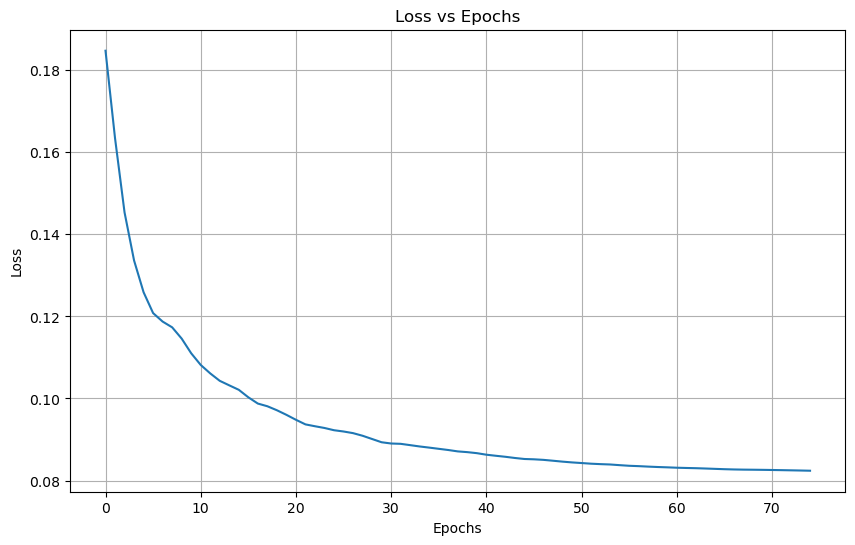

In [9]:
all_losses = best_loss_overall
best_model_pars = best_pars_overall
min_loss = best_rf_overall

print(f"min loss: {min_loss}")

# Plotting the loss values
plt.figure(figsize=(10, 6))

# Plot the loss values for each iteration
for i, loss_values in enumerate(all_losses):
    plt.plot(loss_values, label=f'Iteration {i+1}')

plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.legend()
plt.grid(True)
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_21720\1154777248.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  mode_names = pd.read_csv('C:/Users/User/Desktop/uzh_intern/CrystalClearFit/alrisDistortionFit/PBCO/new_PBCO_fit/displacivemode_names.txt' , delim_whitespace=True, header=None)
C:\Users\User\AppData\Local\Temp\ipykernel_21720\1154777248.py:10: RuntimeWarning: invalid value encountered in scalar divide
  print(f"mode a{i+1} {mode_names.iloc[i, 1]} : {par.numpy()/max_mode_amps[i]:.8f}")


Best model parameters:
mode a1 Pmmm[1/9,1/9,1/3]GP1(a,0;a,0;a,0;a,0)[Pr1:h:dsp]B3u(a) : 0.00000000
mode a2 Pmmm[1/9,1/9,1/3]GP1(a,0;a,0;a,0;a,0)[Pr1:h:dsp]B1u(a) : -0.00000000
mode a3 Pmmm[1/9,1/9,1/3]GP1(a,0;a,0;a,0;a,0)[Pr1:h:dsp]B2u(a) : 0.00000000
mode a4 Pmmm[0,1/9,0]DT1(a,0)[Pr1:h:dsp]B2u(a) : -0.05771445
mode a5 Pmmm[0,2/9,0]DT1(a,0)[Pr1:h:dsp]B2u(a) : 0.30355226
mode a6 Pmmm[0,1/3,0]DT1(a,0)[Pr1:h:dsp]B2u(a) : -0.00000000
mode a7 Pmmm[0,4/9,0]DT1(a,0)[Pr1:h:dsp]B2u(a) : -0.00000000
mode a8 Pmmm[0,0,1/3]LD1(a,0)[Pr1:h:dsp]B1u(a) : 0.08844331
mode a9 Pmmm[1/9,0,0]SM1(a,0)[Pr1:h:dsp]B3u(a) : -0.00000000
mode a10 Pmmm[2/9,0,0]SM1(a,0)[Pr1:h:dsp]B3u(a) : 0.33529056
mode a11 Pmmm[1/3,0,0]SM1(a,0)[Pr1:h:dsp]B3u(a) : 0.00000000
mode a12 Pmmm[4/9,0,0]SM1(a,0)[Pr1:h:dsp]B3u(a) : -0.00000000
mode a13 Pmmm[0,1/9,1/3]K1(a,0;a,0)[Pr1:h:dsp]B1u(a) : 0.13889192
mode a14 Pmmm[0,1/9,1/3]K1(a,0;a,0)[Pr1:h:dsp]B2u(a) : 0.06593152
mode a15 Pmmm[0,2/9,1/3]K1(a,0;a,0)[Pr1:h:dsp]B1u(a) : -0.02790487
m

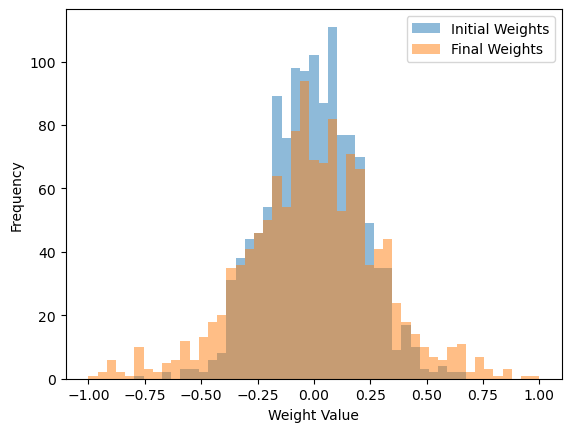

In [10]:
mode_names = pd.read_csv('C:/Users/User/Desktop/uzh_intern/CrystalClearFit/alrisDistortionFit/PBCO/new_PBCO_fit/displacivemode_names.txt' , delim_whitespace=True, header=None)
mode_names = mode_names.values.tolist()
mode_names = pd.DataFrame(mode_names)

max_mode_amps = np.array([5.6,6.36,5.6,11.19,11.19,12.73,11.19,12.73,11.19,11.19,12.73,11.19,9.0,7.91,9.0,7.91,9.0,9.0,9.0,7.91,7.91,9.0,7.91,9.0,9.0,9.0,7.91,9.0,7.91,7.91,7.91,7.91,7.91,9.0,7.91,7.91,7.91,7.91,7.91,7.91,7.91,9.0,7.91,7.91,9.0,7.91,9.0,7.91,9.0,9.0,9.0,7.91,7.91,7.91,7.91,7.91,7.91,9.0,7.91,7.91,5.6,6.36,5.6,5.6,6.36,6.36,5.6,6.36,5.6,5.6,6.36,5.6,5.6,6.36,5.6,5.6,6.36,6.36,5.6,6.36,5.6,6.36,6.36,5.6,6.36,6.36,5.6,6.36,6.36,6.36,6.36,6.36,5.6,5.6,6.36,5.6,5.6,6.36,5.6,5.6,6.36,6.36,5.6,6.36,5.6,8.29,7.91,8.04,8.42,8.04,8.42,0.0,15.59,15.83,15.59,15.83,15.59,18.0,15.59,15.83,15.59,18.0,15.59,15.83,15.59,15.83,15.59,18.0,15.59,15.83,11.73,11.19,11.37,11.91,11.73,11.19,11.37,11.91,11.02,12.73,14.7,12.73,11.73,11.19,11.37,11.91,11.73,11.19,11.37,11.91,11.73,11.19,11.37,11.91,11.02,12.73,14.7,12.73,11.73,11.19,11.37,11.91,11.02,11.19,11.19,11.02,11.19,11.19,11.02,12.73,11.19,11.02,11.19,11.19,11.02,11.19,11.19,11.02,11.19,11.19,11.02,12.73,11.19,11.02,11.19,11.19,11.02,11.19,12.73,11.02,11.19,12.73,11.02,12.73,12.73,11.02,11.19,12.73,11.02,11.19,11.19,11.02,11.19,11.19,11.02,12.73,11.19,11.02,11.19,11.19,7.79,9.0,9.14,7.91,9.14,7.91,8.29,7.91,9.14,9.58,8.04,8.42,8.29,7.91,8.04,8.42,8.04,8.42,7.79,9.0,9.14,7.91,9.14,7.91,8.29,7.91,8.04,8.42,8.04,8.42,8.29,7.91,9.14,9.58,8.04,8.42,7.79,9.0,9.14,7.91,9.14,7.91,8.29,7.91,8.04,8.42,9.14,9.58,8.29,7.91,8.04,8.42,9.14,9.58,7.79,9.0,10.39,9.0,10.39,9.0,8.29,7.91,8.04,8.42,9.14,9.58,8.29,7.91,8.04,8.42,8.04,8.42,7.79,9.0,9.14,7.91,9.14,7.91,8.29,7.91,9.14,9.58,8.04,8.42,8.29,7.91,8.04,8.42,8.04,8.42,5.6,6.36,5.6,11.19,11.19,12.73,11.19,12.73,11.19,11.19,12.73,11.19,9.0,7.91,9.0,7.91,9.0,9.0,9.0,7.91,7.91,9.0,7.91,9.0,9.0,9.0,7.91,9.0,7.91,7.91,7.91,7.91,7.91,9.0,7.91,7.91,7.91,7.91,7.91,7.91,7.91,9.0,7.91,7.91,9.0,7.91,9.0,7.91,9.0,9.0,9.0,7.91,7.91,7.91,7.91,7.91,7.91,9.0,7.91,7.91,5.6,6.36,5.6,5.6,6.36,6.36,5.6,6.36,5.6,5.6,6.36,5.6,5.6,6.36,5.6,5.6,6.36,6.36,5.6,6.36,5.6,6.36,6.36,5.6,6.36,6.36,5.6,6.36,6.36,6.36,6.36,6.36,5.6,5.6,6.36,5.6,5.6,6.36,5.6,5.6,6.36,6.36,5.6,6.36,5.6,7.79,9.0,9.14,7.91,9.14,7.91,0.0,15.59,15.83,15.59,15.83,15.59,18.0,15.59,15.83,15.59,18.0,15.59,15.83,15.59,15.83,15.59,18.0,15.59,15.83,11.02,12.73,12.92,11.19,11.02,12.73,12.92,11.19,11.02,12.73,14.7,12.73,11.02,12.73,12.92,11.19,11.02,12.73,12.92,11.19,11.02,12.73,12.92,11.19,11.02,12.73,14.7,12.73,11.02,12.73,12.92,11.19,11.02,11.19,11.19,11.02,11.19,11.19,11.02,12.73,11.19,11.02,11.19,11.19,11.02,11.19,11.19,11.02,11.19,11.19,11.02,12.73,11.19,11.02,11.19,11.19,11.02,11.19,12.73,11.02,11.19,12.73,11.02,12.73,12.73,11.02,11.19,12.73,11.02,11.19,11.19,11.02,11.19,11.19,11.02,12.73,11.19,11.02,11.19,11.19,7.79,9.0,9.14,7.91,9.14,7.91,7.79,9.0,10.39,9.0,9.14,7.91,7.79,9.0,9.14,7.91,9.14,7.91,7.79,9.0,9.14,7.91,9.14,7.91,7.79,9.0,9.14,7.91,9.14,7.91,7.79,9.0,10.39,9.0,9.14,7.91,7.79,9.0,9.14,7.91,9.14,7.91,7.79,9.0,9.14,7.91,10.39,9.0,7.79,9.0,9.14,7.91,10.39,9.0,7.79,9.0,10.39,9.0,10.39,9.0,7.79,9.0,9.14,7.91,10.39,9.0,7.79,9.0,9.14,7.91,9.14,7.91,7.79,9.0,9.14,7.91,9.14,7.91,7.79,9.0,10.39,9.0,9.14,7.91,7.79,9.0,9.14,7.91,9.14,7.91,5.6,6.36,5.6,11.19,11.19,12.73,11.19,12.73,11.19,11.19,12.73,11.19,9.0,7.91,9.0,7.91,9.0,9.0,9.0,7.91,7.91,9.0,7.91,9.0,9.0,9.0,7.91,9.0,7.91,7.91,7.91,7.91,7.91,9.0,7.91,7.91,7.91,7.91,7.91,7.91,7.91,9.0,7.91,7.91,9.0,7.91,9.0,7.91,9.0,9.0,9.0,7.91,7.91,7.91,7.91,7.91,7.91,9.0,7.91,7.91,5.6,6.36,5.6,5.6,6.36,6.36,5.6,6.36,5.6,5.6,6.36,5.6,5.6,6.36,5.6,5.6,6.36,6.36,5.6,6.36,5.6,6.36,6.36,5.6,6.36,6.36,5.6,6.36,6.36,6.36,6.36,6.36,5.6,5.6,6.36,5.6,5.6,6.36,5.6,5.6,6.36,6.36,5.6,6.36,5.6,8.29,7.91,8.04,8.42,8.04,8.42,0.0,15.59,15.83,15.59,15.83,15.59,18.0,15.59,15.83,15.59,18.0,15.59,15.83,15.59,15.83,15.59,18.0,15.59,15.83,11.02,12.73,12.92,11.19,11.02,12.73,12.92,11.19,11.02,12.73,14.7,12.73,11.02,12.73,12.92,11.19,11.73,11.19,11.37,11.91,11.73,11.19,11.37,11.91,11.02,12.73,14.7,12.73,11.73,11.19,11.37,11.91,11.02,11.19,11.19,11.02,11.19,11.19,11.02,12.73,11.19,11.02,11.19,11.19,11.02,11.19,11.19,11.02,11.19,11.19,11.02,12.73,11.19,11.02,11.19,11.19,11.02,11.19,12.73,11.02,11.19,12.73,11.02,12.73,12.73,11.02,11.19,12.73,11.02,11.19,11.19,11.02,11.19,11.19,11.02,12.73,11.19,11.02,11.19,11.19,8.29,7.91,8.04,8.42,8.04,8.42,8.29,7.91,9.14,9.58,8.04,8.42,8.29,7.91,8.04,8.42,8.04,8.42,8.29,7.91,8.04,8.42,8.04,8.42,8.29,7.91,8.04,8.42,8.04,8.42,8.29,7.91,9.14,9.58,8.04,8.42,8.29,7.91,8.04,8.42,8.04,8.42,7.79,9.0,9.14,7.91,10.39,9.0,7.79,9.0,9.14,7.91,10.39,9.0,7.79,9.0,10.39,9.0,10.39,9.0,7.79,9.0,9.14,7.91,10.39,9.0,8.29,7.91,8.04,8.42,8.04,8.42,8.29,7.91,8.04,8.42,8.04,8.42,8.29,7.91,9.14,9.58,8.04,8.42,8.29,7.91,8.04,8.42,8.04,8.42,8.29,7.91,8.04,8.42,8.04,8.42,0.0,15.59,15.83,15.59,15.83,15.59,18.0,15.59,15.83,15.59,18.0,15.59,15.83,15.59,15.83,15.59,18.0,15.59,15.83,11.73,11.19,11.37,11.91,11.73,11.19,11.37,11.91,11.02,12.73,14.7,12.73,11.73,11.19,11.37,11.91,11.02,12.73,12.92,11.19,11.02,12.73,12.92,11.19,11.02,12.73,14.7,12.73,11.02,12.73,12.92,11.19,11.02,11.19,11.19,11.02,11.19,11.19,11.02,12.73,11.19,11.02,11.19,11.19,11.02,11.19,11.19,11.02,11.19,11.19,11.02,12.73,11.19,11.02,11.19,11.19,11.02,11.19,12.73,11.02,11.19,12.73,11.02,12.73,12.73,11.02,11.19,12.73,11.02,11.19,11.19,11.02,11.19,11.19,11.02,12.73,11.19,11.02,11.19,11.19,8.29,7.91,8.04,8.42,8.04,8.42,7.79,9.0,10.39,9.0,9.14,7.91,8.29,7.91,8.04,8.42,8.04,8.42,8.29,7.91,8.04,8.42,8.04,8.42,8.29,7.91,8.04,8.42,8.04,8.42,7.79,9.0,10.39,9.0,9.14,7.91,8.29,7.91,8.04,8.42,8.04,8.42,8.29,7.91,8.04,8.42,9.14,9.58,8.29,7.91,8.04,8.42,9.14,9.58,7.79,9.0,10.39,9.0,10.39,9.0,8.29,7.91,8.04,8.42,9.14,9.58,8.29,7.91,8.04,8.42,8.04,8.42,8.29,7.91,8.04,8.42,8.04,8.42,7.79,9.0,10.39,9.0,9.14,7.91,8.29,7.91,8.04,8.42,8.04,8.42,7.79,9.0,9.14,7.91,9.14,7.91,0.0,15.59,15.83,15.59,15.83,15.59,18.0,15.59,15.83,15.59,18.0,15.59,15.83,15.59,15.83,15.59,18.0,15.59,15.83,11.02,12.73,12.92,11.19,11.02,12.73,12.92,11.19,11.02,12.73,14.7,12.73,11.02,12.73,12.92,11.19,11.02,12.73,12.92,11.19,11.02,12.73,12.92,11.19,11.02,12.73,14.7,12.73,11.02,12.73,12.92,11.19,11.02,11.19,11.19,11.02,11.19,11.19,11.02,12.73,11.19,11.02,11.19,11.19,11.02,11.19,11.19,11.02,11.19,11.19,11.02,12.73,11.19,11.02,11.19,11.19,11.02,11.19,12.73,11.02,11.19,12.73,11.02,12.73,12.73,11.02,11.19,12.73,11.02,11.19,11.19,11.02,11.19,11.19,11.02,12.73,11.19,11.02,11.19,11.19,7.79,9.0,9.14,7.91,9.14,7.91,7.79,9.0,10.39,9.0,9.14,7.91,7.79,9.0,9.14,7.91,9.14,7.91,7.79,9.0,9.14,7.91,9.14,7.91,7.79,9.0,9.14,7.91,9.14,7.91,7.79,9.0,10.39,9.0,9.14,7.91,7.79,9.0,9.14,7.91,9.14,7.91,7.79,9.0,9.14,7.91,10.39,9.0,7.79,9.0,9.14,7.91,10.39,9.0,7.79,9.0,10.39,9.0,10.39,9.0,7.79,9.0,9.14,7.91,10.39,9.0,7.79,9.0,9.14,7.91,9.14,7.91,7.79,9.0,9.14,7.91,9.14,7.91,7.79,9.0,10.39,9.0,9.14,7.91,7.79,9.0,9.14,7.91,9.14,7.91])

# Print the best model parameters
print("Best model parameters:") 
for i, par in enumerate(best_model_pars):
    print(f"mode a{i+1} {mode_names.iloc[i, 1]} : {par.numpy()/max_mode_amps[i]:.8f}")

plt.hist(initial_weights, bins=np.linspace(-1 , 1 , 50), alpha=0.5, label='Initial Weights')
plt.hist(final_weights, bins=np.linspace(-1 , 1 , 50), alpha=0.5, label='Final Weights')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [11]:

def alris_r_factor(data):
    exp_intensity = data['intensity_exp'] / np.max(data['intensity_exp'])
    exp_intensity = exp_intensity / np.sum(exp_intensity) * 60
    simulated_intensity = data['intensity_sim']
    alris_r_factor = np.sum(np.abs(exp_intensity - simulated_intensity)) / np.sum(np.abs(exp_intensity))
    return alris_r_factor

def plot_plane_sim_vs_exp_DIM1(ax, df, r_factor, norm_plane=False):
    exp_data_0 = df.loc[df['h'] == 0].copy()
    #remove rows where the simulated instensity is less than 1e-4
    exp_data_0[exp_data_0['intensity_sim'] <= 1e-3] = 0
    if norm_plane:
        exp_data_0['intensity_exp'] = exp_data_0['intensity_exp'] / np.sum(exp_data_0['intensity_exp']) * 60
    
    ax.scatter(exp_data_0['k'], exp_data_0['l'], 
               s=np.log10(exp_data_0['intensity_sim'] + 1)* 500 , color='red', edgecolor= None,
               label='Sim', marker=MarkerStyle("o", fillstyle="left"))
    ax.scatter(exp_data_0['k'] , exp_data_0['l'] , s=np.log10(exp_data_0['intensity_exp'] + 1)* 500 , color='blue', edgecolor="black",
               label='Exp', marker=MarkerStyle("o", fillstyle="right"))
    
    ax.set_xlabel(f"k in (0, k, l) [r.l.u.]")
    ax.set_ylabel(f"l in (h, 0, l) [r.l.u.]")
    ax.set_title(f"KL plane for H = 0 (logged) , r-factor: {r_factor:.3f}")
    ax.legend()

def plot_plane_sim_vs_exp_DIM2(ax, df,r_factor, norm_plane=False):
    exp_data_0 = df.loc[df['k'] == 0].copy()
    exp_data_0[exp_data_0['intensity_sim'] <= 1e-3] = 0
    if norm_plane:
        exp_data_0['intensity_exp'] = exp_data_0['intensity_exp'] / np.sum(exp_data_0['intensity_exp']) * 60
    
    ax.scatter(exp_data_0['h'], exp_data_0['l'], 
               s=np.log10(exp_data_0['intensity_sim'] + 1) * 500 , color='red', edgecolor="black",
               label='Sim', marker=MarkerStyle("o", fillstyle="left"))
    ax.scatter(exp_data_0['h'] , exp_data_0['l'] , s=np.log10(exp_data_0['intensity_exp'] + 1) * 500, color='blue', edgecolor="black",
               label='Exp', marker=MarkerStyle("o", fillstyle="right"))
    
    ax.set_xlabel(f"h in (h, 0, l) [r.l.u.]")
    ax.set_ylabel(f"l in (h, 0, l) [r.l.u.]")
    ax.set_title(f"HL plane for K = 0 (logged) , r-factor: {r_factor:.3f}")
    ax.legend()

def plot_plane_sim_vs_exp_DIM3(ax, df, r_factor, l,norm_plane=False):
    exp_data_0 = df.loc[df['l'] == 0].copy()
    exp_data_0[exp_data_0['intensity_sim'] <= 1e-3] = 0
    if norm_plane:
        exp_data_0['intensity_exp'] = exp_data_0['intensity_exp'] / np.sum(exp_data_0['intensity_exp']) * 60
    
    ax.scatter(exp_data_0['h'], exp_data_0['k'], 
            s=np.log10(exp_data_0['intensity_sim'] + 1)* 500 , color='red', edgecolor="black",
            label='Sim', marker=MarkerStyle("o", fillstyle="left"))
    ax.scatter(exp_data_0['h'] , exp_data_0['k'] , s=np.log10(exp_data_0['intensity_exp'] + 1)* 500 , color='blue', edgecolor="black",
            label='Exp', marker=MarkerStyle("o", fillstyle="right"))
    
    ax.set_xlabel(f"h in (h, k, {l}) [r.l.u.]")
    ax.set_ylabel(f"k in (h, k, {l}) [r.l.u.]")
    ax.set_title(f"HK plane for L = 0 (logged) , r-factor: {r_factor:.3f}")
    ax.legend()

ALRIS R-factor: 1.143


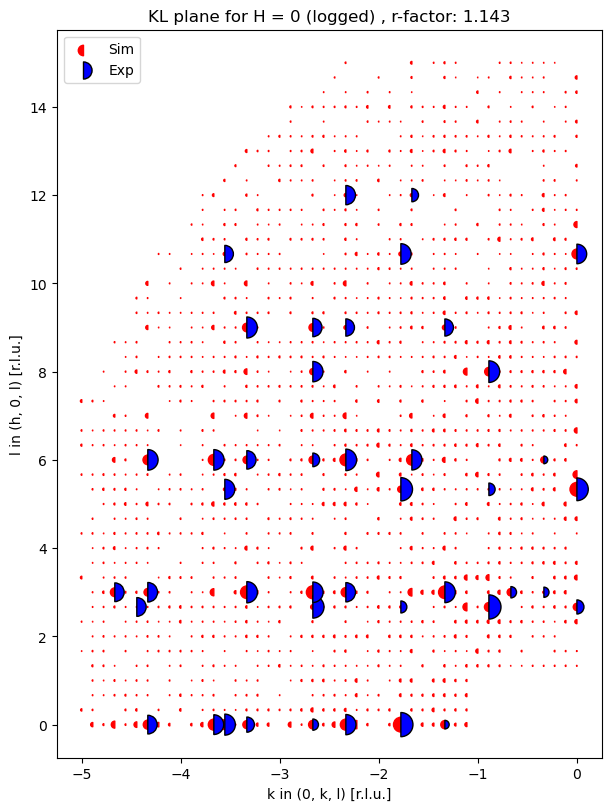

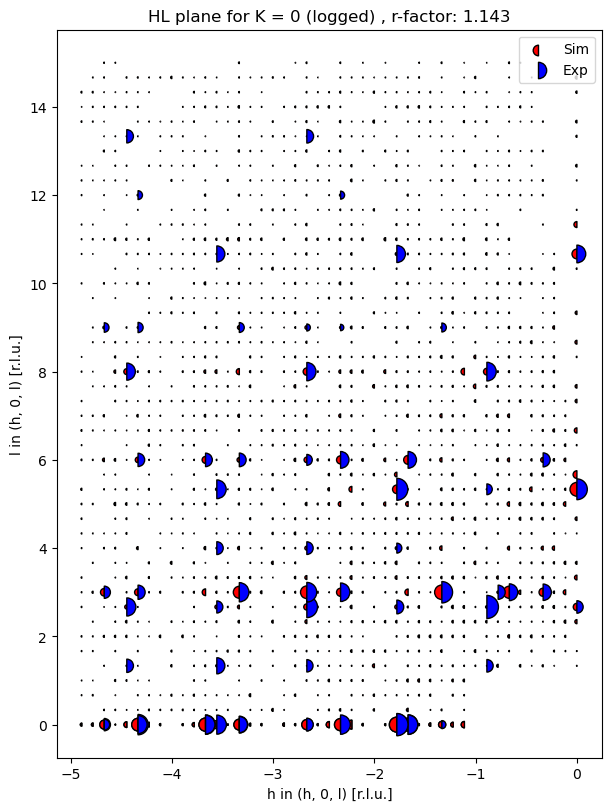

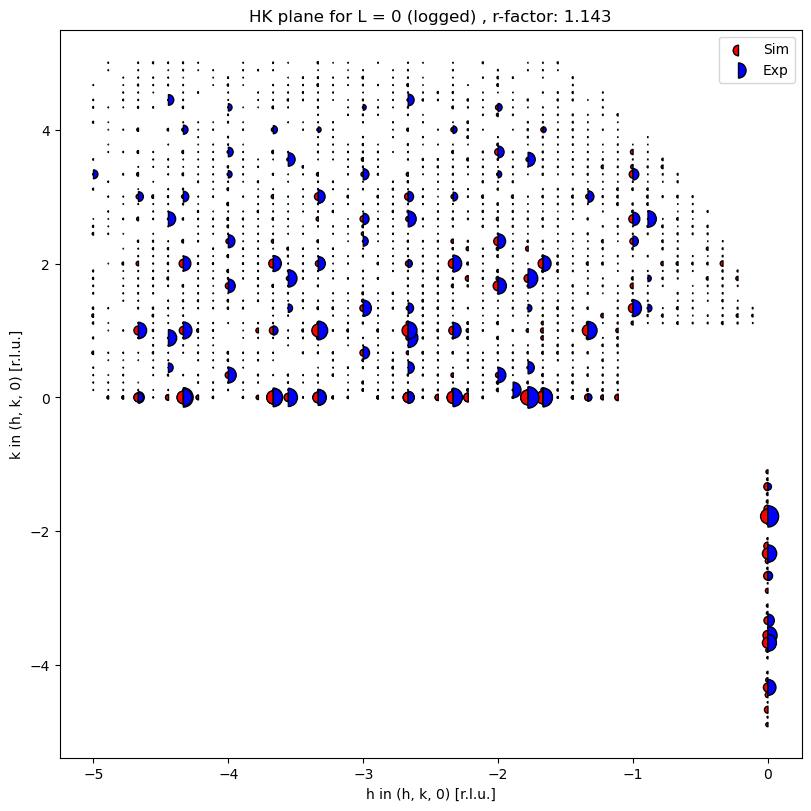

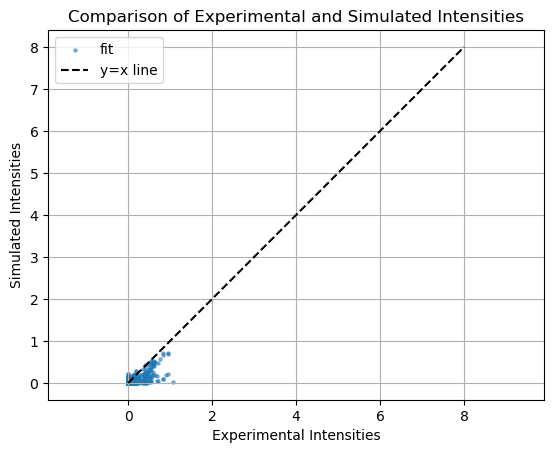

In [12]:
exp_data = pd.read_csv('C:/Users/User/Desktop/uzh_intern/CrystalClearFit/alrisDistortionFit/PBCO/raw_data/LOGcombined_peaks.csv')
exp_data['intensity_sim'] = fun_tf(features, best_model_pars, matrix).numpy()
r_factor = alris_r_factor(exp_data)
print(f"ALRIS R-factor: {r_factor:.3f}")

normalised_exp_data = exp_data['intensity_exp'] / np.sum(exp_data['intensity_exp']) * 60
exp_data['normalised_intensity_exp'] = normalised_exp_data

fig, axs = plt.subplots(1, 1, figsize=(6,8), constrained_layout=True)
exp_data1 = exp_data[0:1775]
plot_plane_sim_vs_exp_DIM1(axs, exp_data, r_factor,norm_plane=True)
plt.show()
fig, axs = plt.subplots(1, 1, figsize=(6,8), constrained_layout=True)
exp_data2 = exp_data[1776:3687]
plot_plane_sim_vs_exp_DIM2(axs, exp_data, r_factor,norm_plane=True)
plt.show()
fig, axs = plt.subplots(1, 1, figsize=(8,8), constrained_layout=True)
exp_data3 = exp_data[3687:]
plot_plane_sim_vs_exp_DIM3(axs, exp_data, r_factor, 0,norm_plane=True)
plt.show()

x = np.linspace(0 ,8, 100)
y = x
plt.scatter(exp_data['intensity_exp']/np.sum(exp_data['intensity_exp']) * 60, exp_data['intensity_sim'], s=5, alpha=0.5 , label='fit')
plt.plot(x , y, color='black', linestyle='--', label='y=x line')
plt.legend()
plt.grid(True)
plt.title('Comparison of Experimental and Simulated Intensities')
plt.xlabel('Experimental Intensities')
plt.ylabel('Simulated Intensities')
plt.axis('equal')
plt.show()


In [16]:
#save the experiment data with simulated intensities
exp_data.to_csv('C:/Users/User/Desktop/uzh_intern/CrystalClearFit/alrisDistortionFit/PBCO/fitted_data/peaks_with_simulated_intensities.txt', index=False)

#save all the parameters and the modes
with open('C:/Users/User/Desktop/uzh_intern/CrystalClearFit/alrisDistortionFit/PBCO/fitted_data/parameters_and_modes.txt', 'w') as f:
    f.write(f"final loss: {min_loss:.8f}\n")
    f.write(f"Number of iterations: {n_iter}\n")
    f.write(f"r_factor: {r_factor:.8f}\n")
    f.write(f"learning_rate: {lr[0]:.8f}\n")
    f.write(f"n_epochs: {n_epochs}\n")
    f.write(f"Best model parameters:\n")
    for i, par in enumerate(best_model_pars):
        f.write(f"{mode_names.iloc[i, 1]} : {par.numpy():.8f} \n")

abs_params = tf.abs(best_model_pars)
best_model_pars_compare = best_model_pars.numpy()
best_model_pars_compare = best_model_pars_compare / np.max(best_model_pars_compare)

#save all the parameters and the modes
with open('C:/Users/User/Desktop/uzh_intern/CrystalClearFit/alrisDistortionFit/PBCO/fitted_data/parameters_and_modes_normalised.txt', 'w') as f:
    f.write(f"final loss: {min_loss:.8f}\n")
    f.write(f"learning_rate: {lr[0]:.8f}\n")
    f.write(f"n_epochs: {n_epochs}\n")
    f.write(f"Best model parameters:\n")
    for i, par in enumerate(best_model_pars_compare):
        f.write(f"{mode_names.iloc[i, 1]} : {par:.8f} \n")



In [17]:
best_data = pd.read_csv('C:/Users/User/Desktop/uzh_intern/CrystalClearFit/alrisDistortionFit/fitted_data/peaks_with_simulated_intensities.txt')

fig, axs = plt.subplots(1, 2, figsize=(24, 12), constrained_layout=True)
plot_plane_sim_vs_exp(axs[0], best_data, 0, norm_plane=True)
plot_plane_sim_vs_exp(axs[1], exp_data, 0, norm_plane=True)

plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/User/Desktop/uzh_intern/CrystalClearFit/alrisDistortionFit/fitted_data/peaks_with_simulated_intensities.txt'